# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE,None,'d:\.fastai/data')
path.ls()

[WindowsPath('d:/.fastai/data/imdb_sample/data_save.pkl'),
 WindowsPath('d:/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head(7)

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False
5,negative,"From the start, you know how this movie will e...",False
6,negative,There were a lot of truly great horror movies ...,False


In [5]:
df['text'][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [5]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [6]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [7]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [8]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [9]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [10]:
data.train_ds[0][0]

Text xxbos xxmaj this movie is xxunk in a ' so bad it 's good ' kind of way . 
 
  xxmaj the storyline is rehashed from so many other films of this kind , that i 'm not going to even bother describing it . xxmaj it 's a sword / sorcery picture , has a kid hoping to realize how important he is in this world , has a " nomadic " xxunk , an evil xxunk / xxunk , a princess , a hairy creature xxrep 4 . you get the point . 
 
  xxmaj the first time i caught this movie was during a very harsh winter . i do n't know why i decided to continue watching it for an extra five minutes before turning the channel , but when i caught site of xxmaj gulfax , i decided to stay and watch it until the end . 
 
  xxmaj gulfax is a white , furry creature akin to xxmaj chewbacca , but not nearly as useful or entertaining to watch . xxmaj he looks like someone glued a bunch of white xxunk carpeting together and forced the actor to wear it . xxmaj there are scenes where it looks like the actor can not move within

But the underlying data is all numbers

In [11]:
data.train_ds[0][0].data[:10]

array([ 2,  5, 21, 29, 16,  0, 18, 13, 63, 50], dtype=int64)

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [12]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [14]:
bs=48


Now let's grab the full dataset for what follows.

In [16]:
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')
path.ls()

[WindowsPath('d:/.fastai/data/imdb/data_clas.pkl'),
 WindowsPath('d:/.fastai/data/imdb/data_lm.pkl'),
 WindowsPath('d:/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('d:/.fastai/data/imdb/models'),
 WindowsPath('d:/.fastai/data/imdb/README'),
 WindowsPath('d:/.fastai/data/imdb/test'),
 WindowsPath('d:/.fastai/data/imdb/tmp_clas'),
 WindowsPath('d:/.fastai/data/imdb/tmp_lm'),
 WindowsPath('d:/.fastai/data/imdb/train'),
 WindowsPath('d:/.fastai/data/imdb/unsup')]

In [17]:
(path/'train').ls()

[WindowsPath('d:/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('d:/.fastai/data/imdb/train/neg'),
 WindowsPath('d:/.fastai/data/imdb/train/pos'),
 WindowsPath('d:/.fastai/data/imdb/train/unsupBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [18]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [19]:
data_lm.show_batch()

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,"com , and we all know what we are letting ourselves in for when we sign up . xxmaj but does it always have to be so mind numbingly dull ? xxbos xxmaj how bad idea was to remake an almost xxmaj oscar xxunk film ? ! xxup xxunk xxup martha is xxup much xxup more xxup better , has deepness , finesse and so on and mainly : a"
2,"so they come out sounding like xxmaj ibsen characters reading xxmaj victorian poetry . xxmaj and the comedic ending , where all of the good guys go to bed happy , is drowned in a dignified despair that feels like they 're finding xxunk upper - lip peace with impending death , rather than reconciling with lovers . xxmaj even xxmaj lancelot and xxmaj antonio exit the film holding their"
3,"to see this , as i always enjoy xxmaj paul xxmaj bettany 's performances . i thought he was very good as xxmaj darwin , and did his best considering the terrible material he had to work with . \n \n xxmaj darwin 's book xxmaj on the xxmaj origin of xxmaj species was one of the most ground - breaking , controversial and innovative publications ever , yet"
4,"kidding . xxmaj and that , to me , is the most disturbing part of the film . xxmaj other than that , find the most obscure video rental store in your town , get the movie , invite all your friends over , and laugh until you cry with xxmaj ghost xxmaj fever . xxbos i have been a huge fan of the original crew of the xxmaj enterprise"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


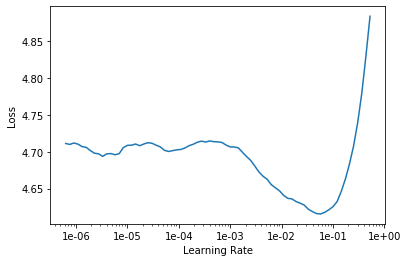

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.153930,4.022134,0.295181,30:57


In [25]:
learn.save('fit_head')

To complete the fine-tuning, we can then unfeeze and launch a new training. Restart kernal here because GPU memory runs out

In [3]:

bs = 48
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fit_head')
learn.unfreeze()

In [8]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.865353,3.809331,0.317833,34:36
1,3.825052,3.771562,0.324421,1:05:14
2,3.768342,3.737499,0.329683,1:00:13
3,3.705749,3.702037,0.333608,34:24
4,3.658146,3.671880,0.337366,34:20
5,3.610883,3.646663,0.340641,34:21
6,3.552748,3.627537,0.342768,34:21
7,3.461658,3.617169,0.344570,34:20
8,3.429755,3.614022,0.344918,34:21
9,3.376823,3.616024,0.344914,34:21


In [9]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [1]:
from fastai.text import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:

bs = 48
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fine_tuned');

In [3]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [4]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because ' . He terms his wife and the 5 on the convincing . It 's rather hard to watch . But , i character he 's trying a do - OVER with a lot of people
I liked this movie because ' with a very subject mind . It is not the same only as The Month ... But it is still far from a classic movie . The Month out other action , editing


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [5]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time. Restart kernal again

In [1]:
from fastai.text import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


In [2]:
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')

bs=32
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [3]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [3]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
path

WindowsPath('d:/.fastai/data/imdb')

In [4]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * * xxmaj attention xxmaj spoilers * * \n \n xxmaj first of all , let me say that xxmaj rob xxmaj roy is one of the best films of the 90 's . xxmaj it was an amazing achievement for all those involved , especially the acting of xxmaj liam xxmaj neeson , xxmaj jessica xxmaj lange , xxmaj john xxmaj hurt , xxmaj brian xxmaj cox",pos
"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact ,",pos
"xxbos xxmaj waitress : xxmaj honey , here 's them eggs you ordered . xxmaj honey , like bee , get it ? xxmaj that 's called pointless foreshadowing . \n \n xxmaj edward xxmaj basket : xxmaj huh ? ( xxmaj on the road ) xxmaj basket : xxmaj here 's your doll back , little girl . xxmaj you really should n't be so careless with your",neg
"xxbos xxup n.b. : xxmaj spoilers within . xxmaj assigning an artistic director to an operatic production naturally and inevitably means you are going to get a piece of that director 's mind . xxmaj but directing a xxmaj wagner opera is an especially tricky task , as he was perhaps the most explicit opera composer in terms of what things should look like and how they should unfold .",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [5]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj story of a man who has unnatural feelings for a pig . xxmaj starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane , violent mob by the crazy xxunk of it 's singers . xxmaj unfortunately it stays absurd the xxup whole time with no general narrative eventually making it just too off putting . xxmaj even those from the era should be turned off . xxmaj the cryptic dialogue would make xxmaj shakespeare seem easy to a third grader . xxmaj on a technical level it 's better than you might think with some good cinematography by future great xxmaj vilmos xxmaj zsigmond . xxmaj future stars xxmaj sally xxmaj kirkland and xxmaj frederic xxmaj forrest can be seen briefly .,xxbos xxmaj airport ' 77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman xxmaj philip xxmaj steven

In [6]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


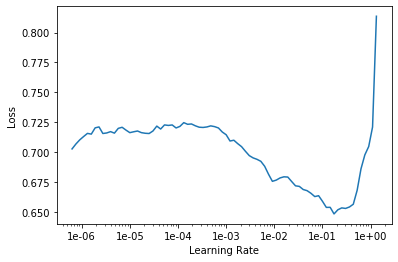

In [10]:
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.568117,0.514207,0.748240,04:31


In [17]:
learn.save('first')


this object has been destroyed


restart kernal after each run

In [1]:
from fastai.text import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
bs = 16
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load('first');

In [3]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.429872,0.389035,0.824200,15:24
1,0.344062,0.317548,0.862480,19:10


In [5]:
learn.save('second')

In [2]:
from fastai.text import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
bs = 8
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load('second');

In [4]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.371893,0.317466,0.868240,37:14
1,0.312645,0.304284,0.886560,42:12


In [5]:
learn.save('third')

In [1]:
from fastai.text import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
bs = 16
path = untar_data(URLs.IMDB,None,'d:\.fastai/data')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load('third');

In [3]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.219731,0.244501,0.901960,20:51
1,0.220219,0.236473,0.905160,19:49


In [6]:
learn.predict("I really loved that movie, it was awesome!")

e:\programs\python\python37\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category pos, tensor(1), tensor([1.6229e-05, 9.9998e-01]))